# Parameter recovery of the DDM with starting point bias

## Simulate individual data

In [1]:
from rlssm.random.random_DDM import simulate_ddm

data = simulate_ddm(
    n_trials=400, 
    gen_drift=.8, 
    gen_threshold=1.3, 
    gen_ndt=.23, 
    gen_rel_sp=.6)

In [2]:
data.describe()[['rt', 'accuracy']]

,rt,accuracy
count,400.000000,400.000000
mean,0.601095,0.825000
std,0.326752,0.380443
min,0.262000,0.000000
25%,0.371500,1.000000
50%,0.494000,1.000000
75%,0.699250,1.000000
max,1.818000,1.000000


## Initialize the model

In [3]:
from rlssm.model.models_DDM import DDModel

model = DDModel(hierarchical_levels = 1, starting_point_bias=True)

## Fit

In [4]:
# sampling parameters
n_warmup = 1500
n_sampling = 1500
n_chains = 2
n_thin = 1

# bayesian model, change default priors:
drift_priors = {'mu':1, 'sd':3}
threshold_priors = {'mu':-1, 'sd':3}
ndt_priors = {'mu':-1, 'sd':1}

In [5]:
model_fit = model.fit(
    data,
    drift_priors=drift_priors,
    threshold_priors=threshold_priors,
    ndt_priors=ndt_priors,
    thin = n_thin,
    iter_warmup=n_warmup,
    iter_sampling=n_sampling,
    chains = n_chains)

Fitting the model using the priors:
drift_priors {'mu': 1, 'sd': 3}
threshold_priors {'mu': -1, 'sd': 3}
ndt_priors {'mu': -1, 'sd': 1}
rel_sp_priors {'mu': 0, 'sd': 0.8}


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

                                                                                                                                                                
Checks MCMC diagnostics:
n_eff / iter looks reasonable for all parameters
0 of 3000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior
0.0 of 3000 iterations ended with a divergence (0.0%)


### get Rhat

In [6]:
model_fit.rhat

,rhat,variable
name,,
lp__,0.999818,lp__
drift,1.002920,drift
threshold,1.001350,threshold
ndt,1.003280,ndt
rel_sp,1.002370,rel_sp
...,...,...
log_lik[396],1.003840,log_lik[396]
log_lik[397],1.004130,log_lik[397]
log_lik[398],1.001970,log_lik[398]


### calculate wAIC

In [7]:
model_fit.waic

{'lppd': -143.48130078806022,
 'p_waic': 3.8030450001386353,
 'waic': 294.5686915763977,
 'waic_se': 48.492086527586515}

## Posteriors

In [8]:
model_fit.samples.describe()

,transf_ndt,transf_threshold,transf_rel_sp,transf_drift
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.227154,1.347566,0.585419,0.863216
std,0.005593,0.035651,0.019158,0.105316
min,0.204707,1.247490,0.507420,0.484337
25%,0.223648,1.323135,0.572606,0.789014
50%,0.227517,1.345905,0.585508,0.863565
75%,0.231100,1.372325,0.598611,0.935705
max,0.242389,1.487720,0.644303,1.193490


In [9]:
import seaborn as sns
sns.set(context = "talk", 
        style = "white", 
        palette = "husl",
        rc={'figure.figsize':(15, 8)})

Here we plot the estimated posterior distributions against the generating parameters, to see whether the model parameters are recovering well:

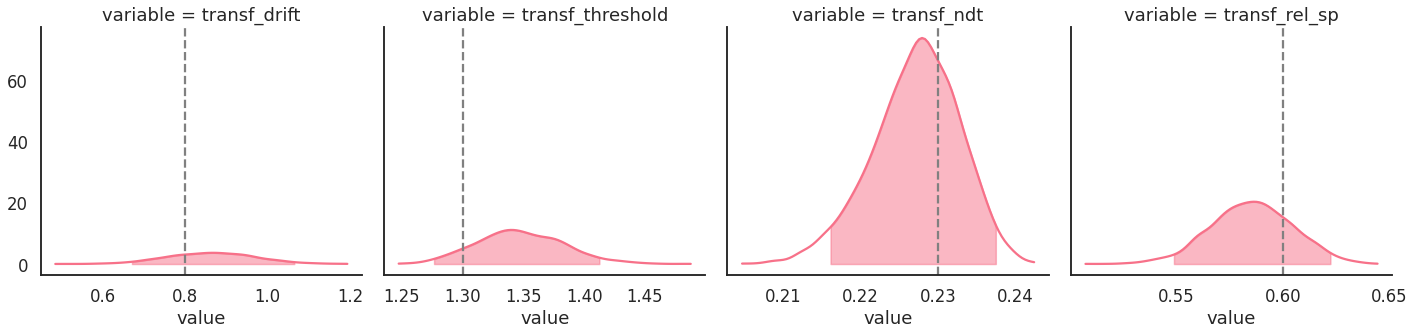

In [10]:
g = model_fit.plot_posteriors(height=5, show_intervals='HDI')

for i, ax in enumerate(g.axes.flatten()):
    ax.axvline(data[['drift', 'threshold', 'ndt', 'rel_sp']].mean().values[i], color='grey', linestyle='--')